In [1]:
import gensim
import praw

import pandas as pd

from praw.models import MoreComments


In [2]:
client_id = 'G8fBBbcIW9LTMw'
client_secret = 'lVZeGZcWcUBFUBC0-CYL32iCUHw'
user_agent = 'athenahacks'
reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

In [55]:
def create_subreddit_df(subreddit, n=10):
    """Create dataframe of top n posts for a given subreddit."""
    posts = []
    subred = reddit.subreddit(subreddit)
    for post in subred.top(limit=n):
        posts.append([post.title, post.id, post.subreddit, post.url, post.selftext])
    subreddit_df = pd.DataFrame(posts,columns=['title', 'id', 'subreddit', 'url',  'body'])
    return subreddit_df

def get_comment_submissions(subreddit_df):
    """Get top comments for a given subreddit."""
    subreddit_comments = []
    for thread_id in subreddit_df['id']:
        submission = reddit.submission(id=thread_id)
        # Allow recursive comment collection
        submission.comments.replace_more(limit=0)
        # collect tuples of (thread, comment)
        # Note - I'm doing tuples so I can easily join back to subreddit_df later
        submission_comments = [(thread_id, sub.body) for sub in submission.comments.list()]
        subreddit_comments.append(submission_comments)
    # unnest all comments
    unnested_comments = [coms for thread in subreddit_comments for coms in thread]
    # coerce to pandas dataframe
    comment_df = pd.DataFrame(unnested_comments, columns=['id', 'comment'])
    return comment_df



In [325]:
import multiprocessing
import praw
import re
import spacy

import pandas as pd

from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from time import time

class ScrapeReddit():
    """
    Scrape reddit threads & comments via praw.
    """
    
    def __init__(self, client_id, client_secret, user_agent):
        # probably bad to store api creds as attributes? it's a demo whatever
        self.client_id = client_id
        self.client_secret = client_secret
        self.user_agent = user_agent
        self.reddit = self.connect_to_api()
        
    def connect_to_api(self):
        """
        Connect to reddit API.
        """
        reddit = praw.Reddit(client_id=self.client_id, 
                             client_secret=self.client_secret, 
                             user_agent=self.user_agent)
        return reddit
    
    def get_thread_df(self, subreddit, n):
        """
        Create dataframe of top n posts for a given subreddit.
        """
        posts = []
        subred = self.reddit.subreddit(subreddit)
        for post in subred.top(limit=n):
            posts.append([post.title, post.id, post.subreddit, post.selftext])
        thread_df = pd.DataFrame(posts, columns=['title', 'id', 'subreddit', 'body'])
        return thread_df
    
    @staticmethod
    def get_comment_submissions(subreddit_df):
        """
        Get top comments for a given subreddit.
        """
        subreddit_comments = []
        for thread_id in subreddit_df['id']:
            submission = reddit.submission(id=thread_id)
            # Allow recursive comment collection
            submission.comments.replace_more(limit=0)
            # collect tuples of (thread, comment)
            submission_comments = [(thread_id, sub.body) for sub in submission.comments.list()]
            subreddit_comments.append(submission_comments)
        # unnest all comments
        unnested_comments = [coms for thread in subreddit_comments for coms in thread]
        # coerce to pandas dataframe
        comment_df = pd.DataFrame(unnested_comments, columns=['id', 'comment'])
        return comment_df
    
    def make_subreddit_df(self, subreddit, n):
        """
        Create subreddit dataframe.
        """
        thread_df = self.get_thread_df(subreddit, n)
        comment_df = self.get_comment_submissions(thread_df)
        subreddit_df = pd.merge(thread_df, comment_df, on='id', how='inner')
        return subreddit_df
            

In [326]:
api = ScrapeReddit(client_id, client_secret, user_agent)
reddit_df = api.make_subreddit_df('gameofthrones', 500)

In [327]:
reddit_df 

,title,id,subreddit,body,comment
0,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,Make sure you [grab a house flair](https://www...
1,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,I wonder whether Jon is standing in front of N...
2,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,Wake me up on April 14 please. Thanks.
3,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,"""Our enemy doesn't stop, doesn't tire, doesn't..."
4,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,Everyone fighting and Cersei is just chilling ...
5,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,"Seeing Arya, a cold blooded assassin run scare..."
6,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,I have a feeling we are about to lose half of ...
7,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,"Aww man, I was enjoying the 15 minute videos a..."
8,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,Jon is sooo gonna ride Rhaegal.\n\nEdit: it's ...
9,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,,Im gonna be so pissed if i die before the seri...


# Combine Text Data

In [328]:
reddit_df['text'] = reddit_df['title'] + reddit_df['body'] + reddit_df['comment']

In [329]:
reddit_df.shape

(180366, 6)

# Remove missing values
In our case, we don't need to worry about missing values; we'll just drop them. In some cases, this isn't always preferable - but no worries

In [330]:
# do we have any NA values. No? dope
reddit_df.isnull().sum()

title        0
id           0
subreddit    0
body         0
comment      0
text         0
dtype: int64

# Preprocess Text

In [ ]:
# fix issue with multiple spellings of character names
name_norms = {
    ''
}

In [331]:
# windows, else replace 'en_core_web_sm' with 'en'
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc, lemmatize=True):
    # remove_stopwords
    txt = [token for token in doc if not token.is_stop]
    # lemmatize
    if lemmatize:
        txt = [token.lemma_ for token in txt]
    # don't return text if it's too short
    if len(txt) > 2:
        return ' '.join(txt)

In [332]:
bad_words = ['com','a', 'www', 'ibb_co', 'r','s', 'b', 'ff', 'f', 'fc', 'cc', 'wiki', 'https', 'https_www', 'reddit_com', 'http', 'r_gameofthrone', 'c', 'jpg', 'gallery',
            'en_wikipedia', 'org', 'np_reddit', 'reddit_gameofthrone', 'policy', 'message', 'guide', 'reminder', 'delete', 'gameofthrone',
            'q', 'link', 'reddit_gameofthrone', 'v', 'comment', 'png', 'w', 'silver', 'gold', 'o', 'youtube_watch', 'post', 'imgur', 'reddit',
            'h', 'n', 'st', 'l', 'g', 'j', 'ibb', 'co', 'gif', 'k', 'gameofthrone', 'comment', 'post', 'x', 'subject',
            'info', 'compose', 'np']

# remove non-alphabetic characters
def filter_text(comment):
    # remove non-alpha characters
    alpha_comment = re.sub("[^A-Za-z']+", ' ', str(comment)).lower()
    # filter out bad words
    tokens = [word.lower() for word in alpha_comment.split() if word.lower() not in bad_words]
    return ' '.join(tokens)
brief_cleaning = (filter_text(row) for row in reddit_df['comment'])

In [333]:
brief_cleaning

<generator object <genexpr> at 0x00000205A014BF68>

In [334]:
from time import time
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.83 mins


In [335]:
len(txt)

180366

In [336]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(136433, 1)

In [337]:
sent = [row.split() for row in df_clean['clean']]

In [338]:
bigram = Phrases(sent, min_count=30, progress_per=5000)

In [339]:
sentences = bigram[sent]

In [340]:
sentences

In [341]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

48507

In [342]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['think',
 'like',
 'know',
 'get',
 'jon',
 'good',
 'time',
 'go',
 'people',
 'book',
 'season',
 'look',
 'say',
 'thing',
 'want',
 'way',
 'love',
 'kill',
 'come',
 'see']

In [343]:
cores = multiprocessing.cpu_count()

In [344]:
cores

8

# word2vec

In [345]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [346]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.11 mins


In [347]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 4.28 mins


In [348]:
# make model more memory efficient
w2v_model.init_sims(replace=True)

In [349]:
# play with model
w2v_model.wv.most_similar(positive=["stoneheart"])

# fix issue with multiple spellings of character names
# name_norms = {
#     'berric': 'beric',
#     'jamie': 'jaime',
#     'jaimie': 'ja'
# }

[('lady_stoneheart', 0.6198210716247559),
 ('lsh', 0.5611170530319214),
 ('beric', 0.5116912126541138),
 ('berric', 0.5082736015319824),
 ('dondarrion', 0.5066328644752502),
 ('resurrect', 0.5058009028434753),
 ('catelyn', 0.4917796850204468),
 ('aso', 0.4917214810848236),
 ('revive', 0.4702329933643341),
 ('thoro', 0.4626932740211487)]

In [390]:
w2v_model.wv.most_similar(positive=["kit"])

[('emilia', 0.6374762058258057),
 ('harrington', 0.5607879161834717),
 ('kit_harington', 0.5269027948379517),
 ('sophie', 0.5141186118125916),
 ('kit_harrington', 0.46147456765174866),
 ('liam_cunningham', 0.4397754371166229),
 ('maisie', 0.4255657196044922),
 ('sophie_turner', 0.4167824983596802),
 ('expressive', 0.4148576557636261),
 ('nikolaj', 0.4066346287727356)]

In [379]:
print(w2v_model.wv.similarity("jon", 'snow'))
print(w2v_model.wv.similarity("jon", 'lannister'))

0.25788406
0.22265883


In [380]:
print(w2v_model.wv.similarity("jon", 'kingslayer'))
print(w2v_model.wv.similarity("jaime", 'kingslayer'))

0.15940414
0.52497923


In [384]:
print(w2v_model.wv.most_similarity("jaime"))

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'most_similarity'

In [382]:
w2v_model.wv.doesnt_match(['jamie', 'tyrion', 'jon', 'tywin'])

'jon'

In [361]:
w2v_model.wv.doesnt_match(['sansa', 'arya', 'littlefinger'])

'arya'

In [362]:
w2v_model.wv.doesnt_match(['lannister', 'stark', 'greyjoy', 'tyrell'])

'greyjoy'

In [394]:
w2v_model.wv.most_similar(positive=["start", "lannister", "sexy"], negative=["stark"], topn=15)

[('shower', 0.30686473846435547),
 ('hot', 0.287539005279541),
 ('skirt', 0.2841108441352844),
 ('toxic', 0.2787433862686157),
 ('alcoholic', 0.27418404817581177),
 ('bun', 0.2723558843135834),
 ('hella', 0.2697514295578003),
 ('rag', 0.2638090252876282),
 ('barrel', 0.2611815631389618),
 ('outfit', 0.2592066526412964),
 ('nudity', 0.25843989849090576),
 ('jacket', 0.25830987095832825),
 ('underneath', 0.25663813948631287),
 ('nowadays', 0.2563632130622864),
 ('leather', 0.2546547055244446)]

In [396]:
w2v_model.wv.most_similar(positive=["hodor", "bron"], topn=10)

[('hold_door', 0.5200660228729248),
 ('pod', 0.43382877111434937),
 ('sam_gilly', 0.41271719336509705),
 ('hodor_hodor', 0.41180095076560974),
 ('meera', 0.4049489200115204),
 ('jojen', 0.3935372233390808),
 ('hoe', 0.39185595512390137),
 ('bronn', 0.3835694193840027),
 ('brienne_tarth', 0.3672548532485962),
 ('jamie', 0.35989910364151)]

In [419]:
%time
w2v_model.wv.most_similar(positive=["wedding"], topn=10)

Wall time: 0 ns


[('wed', 0.5706087350845337),
 ('consummate', 0.5568292140960693),
 ('red_wedding', 0.4543036222457886),
 ('joff', 0.44599586725234985),
 ('ceremony', 0.4455726742744446),
 ('bride', 0.4168156385421753),
 ('arrange', 0.4144287109375),
 ('groom', 0.4118686318397522),
 ('honeymoon', 0.4086294174194336),
 ('marry', 0.40806376934051514)]

# t-sne

In [365]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [366]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

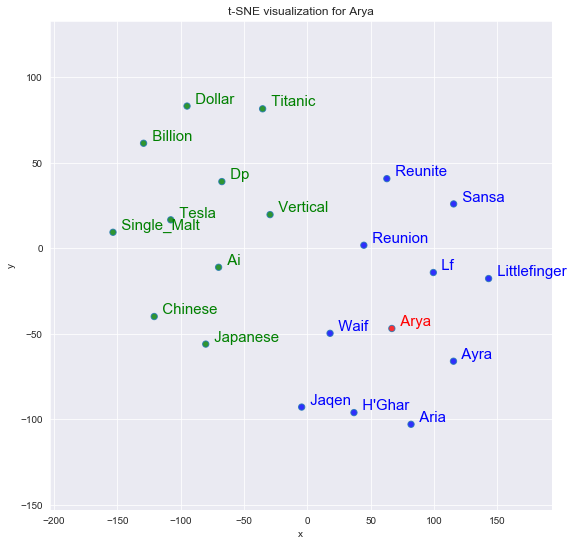

In [367]:
tsnescatterplot(w2v_model, 'arya', [i[0] for i in w2v_model.wv.most_similar(negative=["arya"])])

In [ ]:
bad_words = ['com', 'wiki', 'https', 'https_www', 'reddit_com', 'http', 'r_gameofthrone', 'c', 'jpg', 'gallery']

In [378]:
import difflib
def correct_name(first, second):
    return difflib.SequenceMatcher(first, first, second).ratio() > 0.05

first = ['barca', 'emstrdam', 'Praga']
second = ['New York', 'Amsterdam', 'Barcelona', 'Berlin', 'Prague']

result = [s for f in first for s in second if is_similar(f,s, 0.7)]
print(result)


['Amsterdam', 'Prague']
